

# Project: No Show Appointments Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


>I have selected a dataset which contains info about the the patients who book appontments and then they either show up or they don't. Describe the columns a little.
>Diabetes,  hypertension,etc are boolean values where 0=False and 1=true.
>Handicap has values ranging from 0 to 4, It represents the degree of handicap in a patient with 0 signifying the person has no disabilities and 4 menas the patient has more than 3 disabilities.

> **The questions I have posed with the data are**:
><li>Does sending a reminder via SMS have any impact on patient attendance? By how much?</li>
><li>How much does the degree of handicap effect a patient in keeping up with their appointments?</li>
><li>What factors are important to predict if a patient will show up or not?</li>

In [163]:
#import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [164]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('no_show_appointment.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [165]:
# check the size of the dataset
df.shape

(110527, 14)

In [166]:
#gathering information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [167]:
#check for duplicates
df.duplicated().sum()

0

In [168]:
#check for null values
df.isnull().any().sum()

0

In [169]:
#check data for its different characteristics.
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### Data Cleaning 

**Removing rows**

There are no duplicates or null values in the data set but the minimum value of age is '-1', which means there exists errant data and has to be removed. 

In [170]:
#find the rows where age is -1
age_error = df.query('Age == "-1"')

In [171]:
#remove the rows with errant age
df.drop(age_error.index, inplace=True)
df.query('Age == "-1"').PatientId.any()

False

We can generate waiting time from columns appointment day and scheduled day.

In [172]:
# convert appointment day and scheduled day from string to datetime data type
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110526 non-null  float64            
 1   AppointmentID   110526 non-null  int64              
 2   Gender          110526 non-null  object             
 3   ScheduledDay    110526 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110526 non-null  datetime64[ns, UTC]
 5   Age             110526 non-null  int64              
 6   Neighbourhood   110526 non-null  object             
 7   Scholarship     110526 non-null  int64              
 8   Hipertension    110526 non-null  int64              
 9   Diabetes        110526 non-null  int64              
 10  Alcoholism      110526 non-null  int64              
 11  Handcap         110526 non-null  int64              
 12  SMS_received    110526 non-null  int64              
 13  No-show       

In [173]:
# find the difference between appointment day and scheduled day
df['waiting_time'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df.waiting_time.describe()

count    110526.000000
mean          9.183794
std          15.255034
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: waiting_time, dtype: float64

There is 25% of the data which has negative value of waiting time. Since days cannot be negative, this is errant data and must be removed.

In [174]:
#drop rows where waiting time is in negative value
df.drop(df.query('waiting_time < 0.0').index, axis =0, inplace=True)
df.waiting_time.min()

0

In [175]:
#readjust the index after deleting rows
df.reset_index(drop=True, inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,waiting_time
0,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,1
1,7.336882e+14,5630279,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1
2,3.449833e+12,5630575,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1
3,7.812456e+13,5629123,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,1
4,7.345362e+14,5630213,F,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,No,1


**Dropping Columns**

Determining whether neighbourhood column should be dropped:

In [176]:
df.Neighbourhood.nunique()

80

In [177]:
df.groupby('Neighbourhood')['PatientId'].count()

Neighbourhood
AEROPORTO                 5
ANDORINHAS             1524
ANTÔNIO HONÓRIO         180
ARIOVALDO FAVALESSA     175
BARRO VERMELHO          285
                       ... 
SÃO JOSÉ               1376
SÃO PEDRO              1584
TABUAZEIRO             1924
UNIVERSITÁRIO           112
VILA RUBIM              598
Name: PatientId, Length: 80, dtype: int64

>Conclusion: There are 80 neighbourhoods and patients are distributed randomly among them, so this column does not seem to provide any conclusive information and should be dropped. 

Along with column 'Neighbourhood', columns 'PatientId' and 'AppointmentID' also have no determinance on the outcome and can be dropped. Columns 'ScheduledDay' and 'AppointmentDay' have served their purpose in generating the waiting time and are no longer needed.

In [178]:
#remove columns
df= df.drop(['PatientId','AppointmentID', 'Neighbourhood','ScheduledDay','AppointmentDay'], axis=1)
df.head(1)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,waiting_time
0,F,76,0,1,0,0,0,0,No,1


**Changing column names**

In the data there are columns which have been spelt wrongly and there is mismatch in the format of column names as well.

In [179]:
#correcting the spellings of column names
df.rename(columns = {'Hipertension':'hypertension', 'Handcap':'handicap'}, inplace = True)
df.head(1)

,Gender,Age,Scholarship,hypertension,Diabetes,Alcoholism,handicap,SMS_received,No-show,waiting_time
0,F,76,0,1,0,0,0,0,No,1


In [180]:
#keep all the column name in same format and in lowercase
df.rename(columns=lambda x: x.strip().lower().replace("-", "_"), inplace=True)
df.columns

Index(['gender', 'age', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'no_show', 'waiting_time'],
      dtype='object')

**Changing data type**

For explanantory analysis it is best that the data type of 'no_show' column is in numeric format.

In [181]:
#we replace 'No' by 1 and 'Yes' by 0 in the 'no_show' column
df['no_show'].replace(['No','Yes'], [1,0],inplace=True)

In [182]:
#checking if changes have taken affect
df.no_show.describe()

count    71959.000000
mean         0.714810
std          0.451508
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: no_show, dtype: float64

<a id='eda'></a>
## Exploratory Data Analysis


We start by creating masks of patients which show up and another for those who don't.

In [183]:
#mask for patients who showed up, i.e. no_show == "No"
present = df.no_show == 1
#mask for patients who did not show up, i.e. no_show == "Yes"
absent=df.no_show == 0

### Q1  Does sending a reminder via SMS have any impact on patient attendance? By how much?

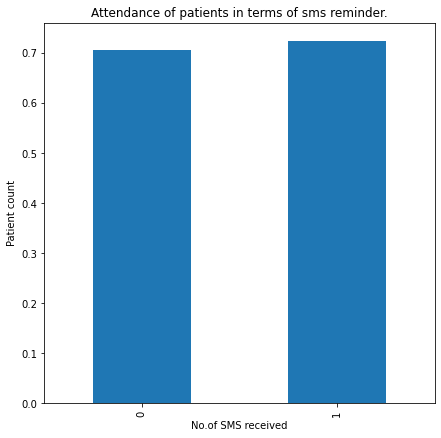

In [184]:
sms_df = df.groupby('sms_received').no_show.mean()
sms_df.plot(kind = 'bar', figsize=(7,7));
plt.title('Attendance of patients in terms of sms reminder.')
plt.xlabel('No.of SMS received');
plt.ylabel('Patient count');

In [185]:
#find by how much over here.
diff = sms_df[1]- sms_df[0]
diff

0.018631830436867447

As seen in the graph the no.of people who reached for their appointment and got an sms reminder are more by a fator of 0.019, than those who did not get and sms reminder but showed up for the appointment.

### Q2  How does disability in a patient affect their attendance? Does the degree of disability matter?

In [186]:
df.handicap[present].mean()

0.02072438128195657

In [187]:
df.handicap[absent].mean()

0.018273072799922036

0.2234967047067286 0.17230289445473151


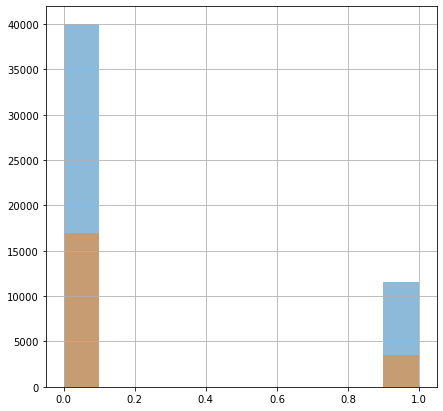

In [200]:
a =df.hypertension[present].mean()
b =df.hypertension[absent].mean()
print(a,b)
df.hypertension[present].hist(figsize=(7,7),alpha=0.5, label= 'present')
df.hypertension[absent].hist(figsize=(7,7), alpha=0.5, label= 'absent');

0.023348951144118047 0.03026020855667089


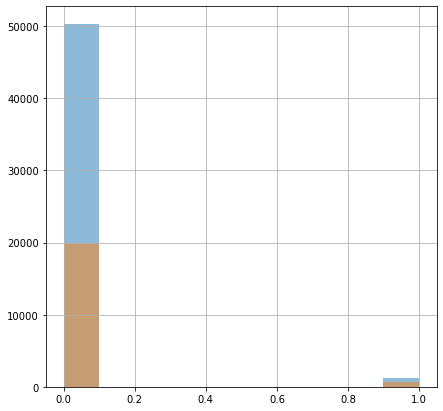

In [201]:
a =df.alcoholism[present].mean()
b =df.alcoholism[absent].mean()
print(a,b)
df.alcoholism[present].hist(figsize=(7,7),alpha=0.5, label= 'present')
df.alcoholism[absent].hist(figsize=(7,7), alpha=0.5, label= 'absent');

0.07844547699127087 0.06539323652665432


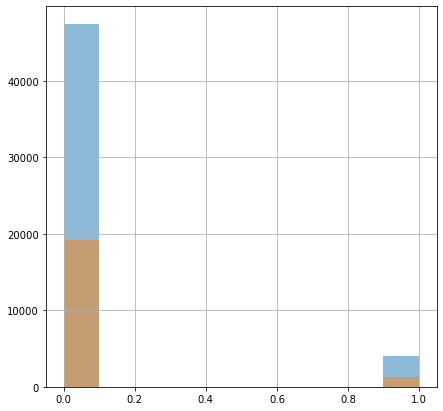

In [202]:
a =df.diabetes[present].mean()
b =df.diabetes[absent].mean()
print(a,b)
df.diabetes[present].hist(figsize=(7,7),alpha=0.5, label= 'present')
df.diabetes[absent].hist(figsize=(7,7), alpha=0.5, label= 'absent');

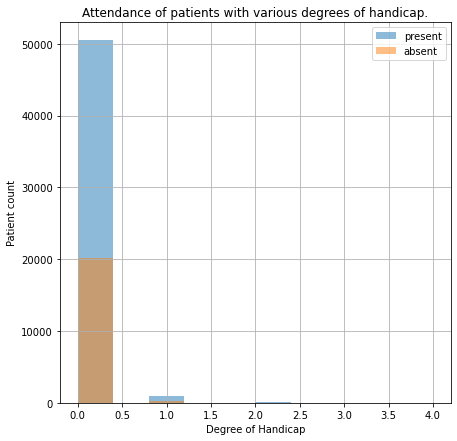

In [188]:
df.handicap[present].hist(figsize=(7,7),alpha=0.5, label= 'present')
df.handicap[absent].hist(figsize=(7,7), alpha=0.5, label= 'absent')
plt.title('Attendance of patients with various degrees of handicap.')
plt.xlabel('Degree of Handicap');
plt.ylabel('Patient count');
plt.legend();

Most of the people who do not have any disability show up for their appointments.

**Degree of handicap**

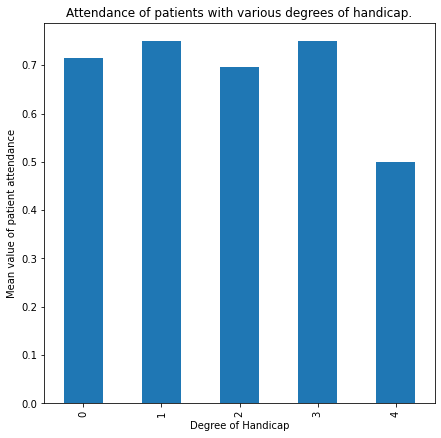

In [189]:
df.groupby('handicap').no_show.mean().plot(kind = 'bar',figsize=(7,7));
plt.title('Attendance of patients with various degrees of handicap.')
plt.xlabel('Degree of Handicap');
plt.ylabel('Mean value of patient attendance');

According to the plot, there is no clear trend between degree of handicap and whether a patient shows up or not but we can conclude that people with 4 or more disabilities tend to miss their appointments significantly more than all the other categories.


### Q3 What factors are important to predict if a patient will show up or not?

**Relationship with waiting time**

In [190]:
df.waiting_time[present].mean()

14.013142290569046

In [191]:
df.waiting_time[absent].mean()

16.21825358152227

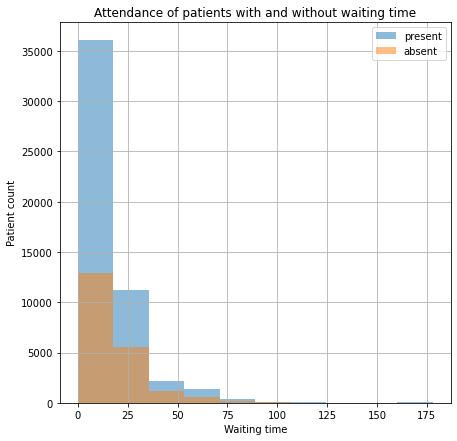

In [192]:
df.waiting_time[present].hist(figsize=(7,7), alpha=0.5, label= 'present')
df.waiting_time[absent].hist(figsize=(7,7), alpha=0.5, label='absent')
plt.title('Attendance of patients with and without waiting time')
plt.xlabel('Waiting time');
plt.ylabel('Patient count');
plt.legend();

The median for those who are present is to the left a lot more than for those who are absent. The more the waiting time, the less gap between present and absent, meaning more people do not show up for their appointment.

**Relationship with scholarship**

In [193]:
df.scholarship[present].mean()

0.08433617823745553

In [194]:
df.scholarship[absent].mean()

0.11368287691258162

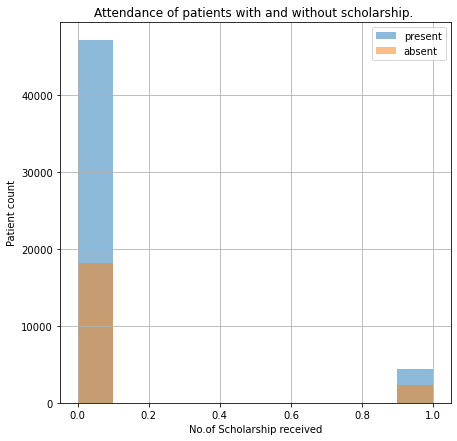

In [195]:
df.scholarship[present].hist(figsize=(7,7),alpha=0.5, label= 'present')
df.scholarship[absent].hist(figsize=(7,7), alpha=0.5, label= 'absent')
plt.title('Attendance of patients with and without scholarship. ')
plt.xlabel('No.of Scholarship received');
plt.ylabel('Patient count');
plt.legend();

<!-- We can see that more people that are present do not have a scholarship. The pateints who don't show up , many do have scholarship ,although not major of them.

For the people who don't show up more than half of them have a scholarship. -->

The people who don't have a scholarship covering their expenses, tend to show up for appointments most of the time.

**Relationship with gender**

In [196]:
# find the poportion of females which don't show up and the proportion of males that don't show up. then compare.
females = df.query('gender == "F"')
males = df.query('gender == "M"')

In [197]:
# proportion of females and males who did not show up
prop_m = males.no_show.mean()
prop_f = females.no_show.mean()
prop_f,prop_m

(0.7155398377366341, 0.7133408681820085)

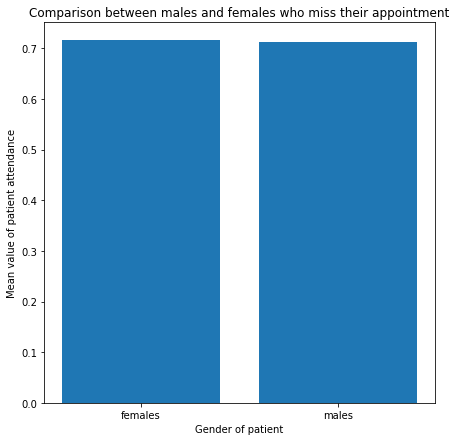

In [198]:
# graph showing proportion of females and males who did not show up
plt.subplots(figsize=(7, 7))
plt.bar(["females","males"],[prop_f,prop_m],)
plt.title('Comparison between males and females who miss their appointment')
plt.xlabel('Gender of patient');
plt.ylabel('Mean value of patient attendance');

There is hardly any difference among the attendance of male and female patients, the the attendance of female patients being slightly higher.

<a id='conclusions'></a>
## Conclusions


> **Limitations:**
><li>There was lots of errant data while calculating waiting time which had to be removed. So, my analysis on waiting time is based on a limited data sample.</li>
><li>I did not explore the effects of hypertension, alcoholism and diabetes on the patient attendance.</li>
><li>I did not explore relationship of patient age with patient attendance because there is significant amount of data where the patient age is 0, i.e., they are unborn children. Since, pregnant women form a separate category themselves, I did not want to do an overall age analysis on their basis. </li>
><li>There was no data entry regarding how many sms reminders were sent to a patient. This information can impact how we determine patient attendance. </li>

As per my data analysis, I can conclude that there is a greater probability of a patient showing up if the waiting time for the appointment is less, he/ she does not have disability or if disability is present,then the no.of disabilities is not 4 or more than 4 and  the patient receives an SMS reminder for the scheduled appointment. Also a patient who is not covered under any health scholarship usually keeps up with their appointment. Gender of the patient is not a significant factor in determining whether a patient will show up or not but the scales tip slightly in favour of female patients.